# Read data

In [281]:
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

In [292]:
activity_cols = {
    "Datum": "date",
    "Ø Pace": "activity_pace_average",
    "Kalorien": "activity_calories",
    "Zeit": "activity_duration",
    "Ø Herzfrequenz": "activity_heart_rate_average",
    "Ø Atemfrequenz": "activity_breathing_rate_average",
}
df_activities = pd.read_csv(
    "data/raw/all_activities.csv",
    usecols=list(activity_cols.keys())
)
df_activities.rename(columns=activity_cols, inplace=True)

sleep_cols = {
    "Sleep Score 7 Tage": "date",
    "Score": "sleep_score",
    "Dauer": "sleep_duration",
    "Schlafenszeit": "sleep_bedtime",
    "Ruheherzfrequenz": "sleep_resting_heart_rate",
    "HFV-Status": "sleep_hrv_status",
    "Atmung": "sleep_breathing_rate",
    "Schlafbedürfnis": "sleep_duration_needed",
}
df_sleep = pd.read_csv(
    "data/raw/sleep.csv",
    usecols=list(sleep_cols.keys())
)
df_sleep.rename(columns=sleep_cols, inplace=True)

# Clean data/time features

## Activities

In [293]:
def pace_to_seconds(pace_str):
    try:
        if isinstance(pace_str, str) and ":" in pace_str:
            parts = pace_str.split(":")
            if len(parts) == 2:
                minutes, seconds = int(parts[0]), int(parts[1])
                return minutes * 60 + seconds
            elif len(parts) == 3:  # If format is HH:MM:SS
                hours, minutes, seconds = int(
                    parts[0]), int(parts[1]), int(parts[2])
                return hours * 3600 + minutes * 60 + seconds
        return float(pace_str)
    except Exception:
        return 0


df_activities["date"] = pd.to_datetime(df_activities["date"], errors="coerce")
df_activities["activity_starting_time"] = df_activities["date"] - df_activities["date"].dt.normalize()
df_activities["date"] = df_activities["date"].dt.normalize()

df_activities["activity_pace_average"] = df_activities["activity_pace_average"].apply(pace_to_seconds)
df_activities["activity_duration"] = pd.to_timedelta(df_activities["activity_duration"], errors="coerce")
df_activities["activity_duration_seconds"] = df_activities["activity_duration"].dt.total_seconds().fillna(0).astype(int)

df_activities["activity_ending_time"] = df_activities["activity_starting_time"] + df_activities["activity_duration"]


In [294]:
numeric_columns = [
    "activity_calories",
    "activity_heart_rate_average",
    "activity_pace_average",
    "activity_breathing_rate_average",
]

for col in numeric_columns:
    if df_activities[col].dtype == "object":
        df_activities[col] = pd.to_numeric(df_activities[col].str.replace(',', '').replace('--', '0'), errors='coerce')
    else:
        df_activities[col] = pd.to_numeric(df_activities[col], errors='coerce')

## Sleep

In [295]:
df_sleep["date"] = pd.to_datetime(df_sleep["date"], errors="coerce")

df_sleep = df_sleep[df_sleep["sleep_bedtime"] != "--"]

df_sleep["sleep_bedtime"] = pd.to_timedelta(
    pd.to_datetime(df_sleep["sleep_bedtime"].astype(str), format="%I:%M %p").dt.hour * 3600 +
    pd.to_datetime(df_sleep["sleep_bedtime"].astype(str), format="%I:%M %p").dt.minute * 60,
    unit="s"
)

# Handle AM times by adding 24 hours to times before noon
mask = df_sleep["sleep_bedtime"].dt.components['hours'] < 12
df_sleep.loc[mask, "sleep_bedtime"] = df_sleep.loc[mask, "sleep_bedtime"] + pd.Timedelta(days=1)

df_sleep["sleep_duration"] = pd.to_timedelta(df_sleep["sleep_duration"], errors="coerce")
df_sleep["sleep_duration_seconds"] = (df_sleep["sleep_duration"]).dt.total_seconds()
df_sleep["sleep_duration_needed"] = pd.to_timedelta(df_sleep["sleep_duration_needed"], errors="coerce")
df_sleep["sleep_duration_needed_seconds"] = (df_sleep["sleep_duration_needed"]).dt.total_seconds() 

df_sleep["sleep_duration_needed_delta"] = df_sleep["sleep_duration"] - df_sleep["sleep_duration_needed"]
df_sleep["sleep_duration_needed_delta_seconds"] = (df_sleep["sleep_duration_needed_delta"]).dt.total_seconds()

In [296]:
numeric_columns = [
    "sleep_score",
    "sleep_resting_heart_rate",
    "sleep_hrv_status",
    "sleep_breathing_rate",
]

for col in numeric_columns:
    if df_sleep[col].dtype == "object":
        df_sleep[col] = pd.to_numeric(df_sleep[col].str.replace(',', '').replace('--', '0'), errors='coerce')
    else:
        df_sleep[col] = pd.to_numeric(df_sleep[col], errors='coerce')

## Combined

In [297]:
df_latest_activity = df_activities.sort_values('activity_ending_time').groupby('date', as_index=False).last()

df_combined = pd.merge(df_latest_activity, df_sleep, on='date', how='right')

if "activity_ending_time" in df_combined.columns and "sleep_bedtime" in df_combined.columns:
    df_combined["bedtime_activity_ending_delta"] = df_combined["sleep_bedtime"] - df_combined["activity_ending_time"]


## Save cleaned data

In [298]:
df_combined.to_csv("data/cleaned/combined_activities_sleep.csv", index=False)

## Data overview

In [299]:
df_combined.head(30)

date  activity_calories activity_duration  \
0  2025-09-30                NaN               NaT   
1  2025-09-29                NaN               NaT   
2  2025-09-28                NaN               NaT   
3  2025-09-27                NaN               NaT   
4  2025-09-26                NaN               NaT   
5  2025-09-25                NaN               NaT   
6  2025-09-24                NaN               NaT   
7  2025-09-23                NaN               NaT   
8  2025-09-22                NaN               NaT   
9  2025-09-21             2817.0   0 days 04:35:15   
10 2025-09-20              246.0   0 days 00:20:13   
11 2025-09-19              210.0   0 days 00:30:18   
12 2025-09-18                NaN               NaT   
13 2025-09-17                NaN               NaT   
14 2025-09-16                NaN               NaT   
15 2025-09-15              350.0   0 days 00:30:39   
16 2025-09-14                NaN               NaT   
17 2025-09-13              549.0   0 days 00:44:56   
18 2025-09-12                NaN               NaT   
19 2025-09-11                NaN               NaT   
20 2025-09-10              573.0   0 days 00:50:07   
21 2025-09-09              491.0   0 days 00:40:03   
22 2025-09-08                NaN               NaT   
23 2025-09-07              873.0   0 days 01:19:19   
24 2025-09-06              510.0   0 days 00:43:57   
25 2025-09-05                NaN               NaT   
26 2025-09-04              511.0   0 days 00:44:12   
27 2025-09-03              326.0   0 days 01:19:34   
28 2025-09-02              605.0   0 days 00:50:10   
29 2025-09-01              301.0   0 days 00:32:51   

    activity_heart_rate_average  activity_pace_average  \
0                           NaN                    NaN   
1                           NaN                    NaN   
2                           NaN                    NaN   
3                           NaN                    NaN   
4                           NaN                    NaN   
5                           NaN                    NaN   
6                           NaN                    NaN   
7                           NaN                    NaN   
8                           NaN                    NaN   
9                         148.0                  387.0   
10                        144.0                  326.0   
11                        116.0                   25.4   
12                          NaN                    NaN   
13                          NaN                    NaN   
14                          NaN                    NaN   
15                        133.0                  328.0   
16                          NaN                    NaN   
17                        144.0                  299.0   
18                          NaN                    NaN   
19                          NaN                    NaN   
20                        135.0                  322.0   
21                        143.0                  294.0   
22                          NaN                    NaN   
23                        136.0                  337.0   
24                        141.0                  335.0   
25                          NaN                    NaN   
26                        137.0                  331.0   
27                         93.0                    0.0   
28                        141.0                  305.0   
29                        117.0                   33.9   

    activity_breathing_rate_average activity_starting_time  \
0                               NaN                    NaT   
1                               NaN                    NaT   
2                               NaN                    NaT   
3                               NaN                    NaT   
4                               NaN                    NaT   
5                               NaN                    NaT   
6                               NaN                    NaT   
7                               NaN    

In [300]:
df_combined.dtypes

date                                    datetime64[ns]
activity_calories                              float64
activity_duration                      timedelta64[ns]
activity_heart_rate_average                    float64
activity_pace_average                          float64
activity_breathing_rate_average                float64
activity_starting_time                 timedelta64[ns]
activity_duration_seconds                      float64
activity_ending_time                   timedelta64[ns]
sleep_score                                      int64
sleep_resting_heart_rate                         int64
sleep_breathing_rate                           float64
sleep_hrv_status                                 int64
sleep_duration                         timedelta64[ns]
sleep_duration_needed                  timedelta64[ns]
sleep_bedtime                          timedelta64[ns]
sleep_duration_seconds                         float64
sleep_duration_needed_seconds                  float64
sleep_dura

# Visualizations

## Corelation Matrix sleep after all activities

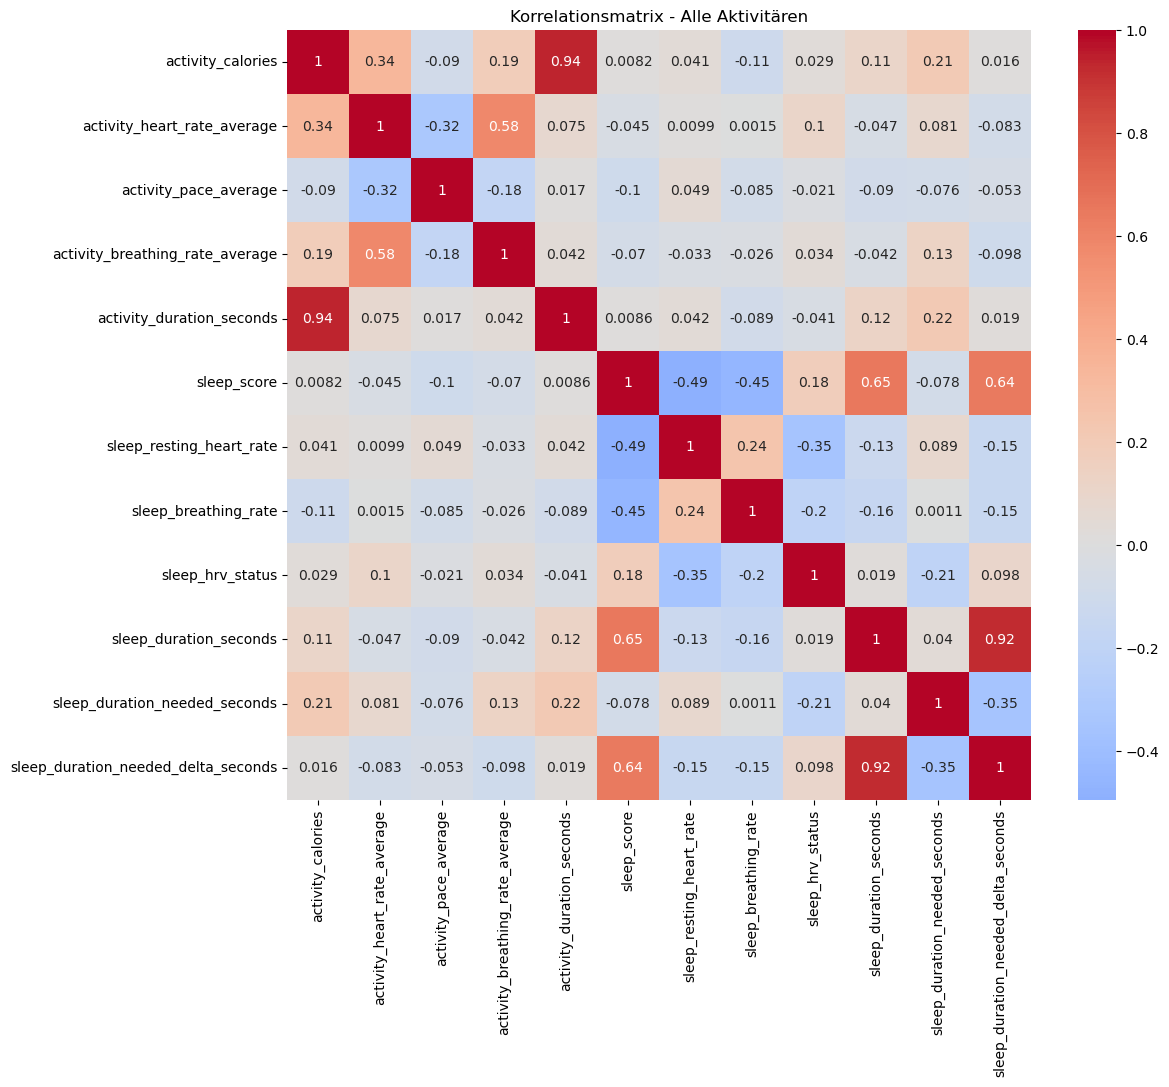

In [301]:
filtered_all_activities = df_combined[(df_combined["activity_calories"].notna())]
correlation_matrix = df_combined.corr(numeric_only=True)

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Korrelationsmatrix - Alle Aktivitären")
plt.show()

## Corelation Matrix sleep after activities < 4h before sleep

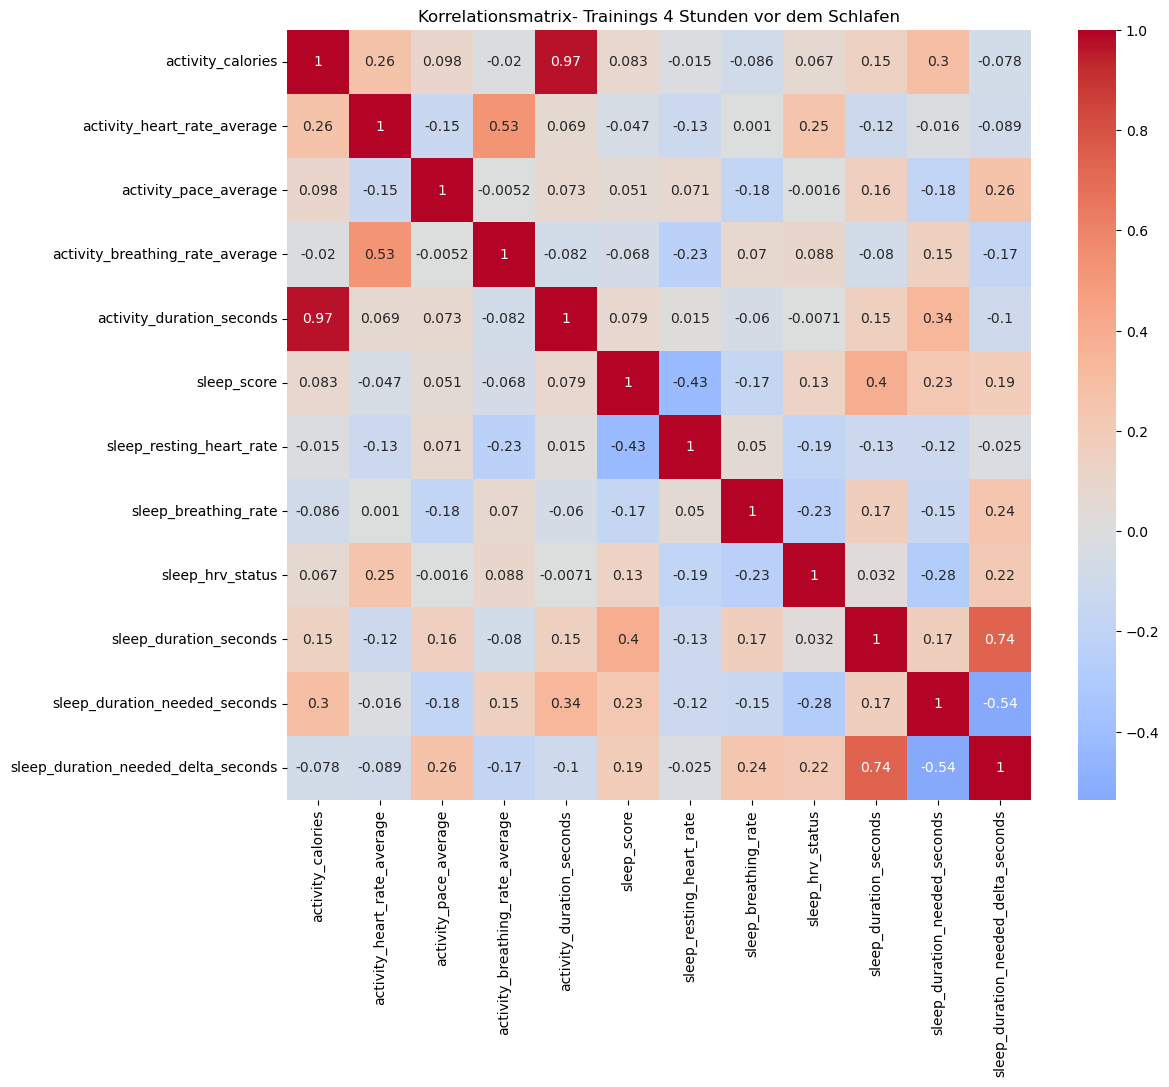

In [302]:

df_combine_activities_4_hours_before_sleep = df_combined[(df_combined["activity_calories"].notna()) & (
    df_combined["bedtime_activity_ending_delta"] < pd.Timedelta(hours=4))]

correlation_matrix = df_combine_activities_4_hours_before_sleep.corr(
    numeric_only=True)

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Korrelationsmatrix- Trainings 4 Stunden vor dem Schlafen")
plt.show()

## Scatter plot

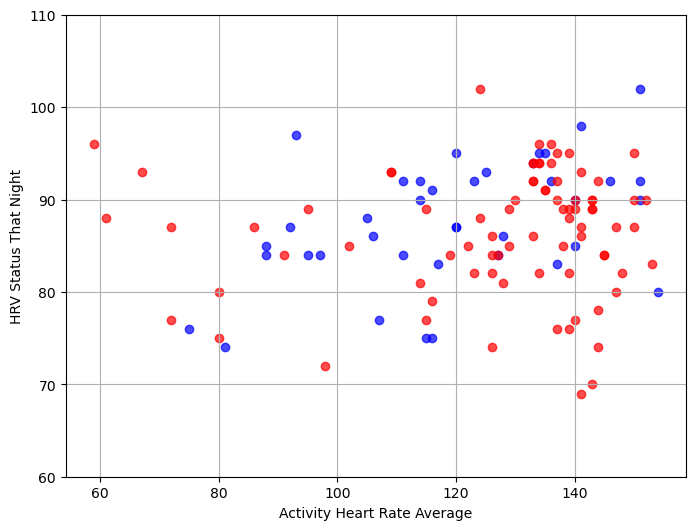

Number of blue points: 39
Number of red points: 81


In [303]:
import matplotlib.pyplot as plt

filtered_df_combined_4h_before_sleep = df_combine_activities_4_hours_before_sleep[
    (df_combine_activities_4_hours_before_sleep["activity_calories"].notna()) &
    (df_combine_activities_4_hours_before_sleep['sleep_duration_needed_delta'].abs() < pd.Timedelta(hours=0.5))
]
plt.figure(figsize=(8, 6))
plt.scatter(
    filtered_df_combined_4h_before_sleep['activity_heart_rate_average'],
    filtered_df_combined_4h_before_sleep['sleep_hrv_status'],
    alpha=0.7,
    color='blue'
)
filtered_df_combined_more_than_4h_before_sleep = df_combined[
     (df_combined["activity_calories"].notna()) &
     (df_combined["bedtime_activity_ending_delta"] > pd.Timedelta(hours=4))&
     (df_combined['sleep_duration_needed_delta'].abs() < pd.Timedelta(hours=0.5))
 ]

plt.scatter(
    filtered_df_combined_more_than_4h_before_sleep['activity_heart_rate_average'],
    filtered_df_combined_more_than_4h_before_sleep['sleep_hrv_status'],
    alpha=0.7,
    color='red',
)

plt.xlabel('Activity Heart Rate Average')
plt.ylabel('HRV Status That Night')
plt.ylim(60, 110)
plt.grid(True)
plt.show()


print(f'Number of blue points: {len(filtered_df_combined_4h_before_sleep)}')
print(f'Number of red points: {len(filtered_df_combined_more_than_4h_before_sleep)}')
